In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle

from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from functools import partial

from neural_nets.MLP import *
from neural_nets.CNN import * 

from inference.bnn import *
import inference.guides as guides
import inference.likelihoods as likelihoods
import inference.priors as priors
from inference.util import *

import examples.helpers as helpers

redo_nuts = False

/home/neklein/anaconda3/envs/multiverse/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


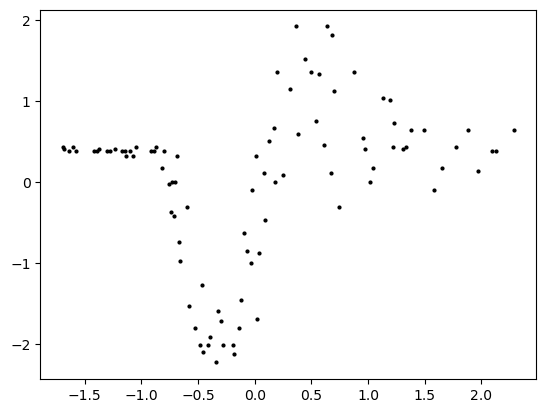

In [2]:
# Read in motorcycle dataset
df = pd.read_table('data/motor.dat', skiprows=37)

X_train = df.times.values
Y_train = df.accel.values

# standardize
X_mean = np.mean(X_train)
X_train -= X_mean
X_std = np.std(X_train)
X_train /= X_std
Y_mean = np.mean(Y_train)
Y_train -= Y_mean
Y_std = np.std(Y_train)
Y_train /= Y_std

plt.plot(X_train,Y_train,'o', color='black', markersize=2)

data = TensorDataset(torch.from_numpy(X_train).float().unsqueeze(1),torch.from_numpy(Y_train).float().unsqueeze(1))
batchsize = 16
train_loader = DataLoader(data, batch_size = batchsize, shuffle = True)

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

## Hamiltonian Monte Carlo

In [3]:
wp = 1.
#nprec = .1**-2
n = X_train.shape[0]

prior = priors.IIDPrior((dist.Normal(torch.tensor(0., device=device), torch.tensor(wp ** -0.5, device=device))))
#likelihood = likelihoods.HomoskedasticGaussian(n, precision=nprec)
likelihood = likelihoods.HeteroskedasticGaussian(n)
kernel = pyro.infer.mcmc.NUTS
net = MLP(in_dim=1, out_dim=2, width=10, depth=2, activation="tanh", device=device).to(device)
hmc_mlp = MCMC_BNN(net, prior, likelihood, kernel_builder=kernel)

In [4]:
warmup_steps = 100
num_samples = 200
num_chains = 1

if redo_nuts:
    mcmc = hmc_mlp.fit(train_loader, num_samples=num_samples, batch_data=True, warmup_steps=warmup_steps, num_chains = num_chains, disable_progbar=False).get_samples()


In [5]:
X_range = torch.linspace(np.min(X_train)-0.2,np.max(X_train)+0.2,1000)
if redo_nuts:
    pred = hmc_mlp.predict(X_range.unsqueeze(-1),num_predictions=5000, aggregate=False)

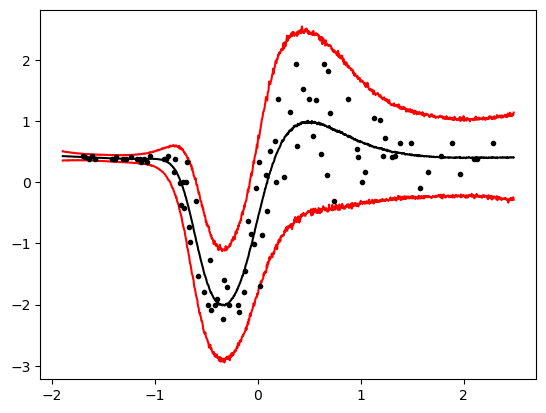

In [6]:
# Draw from the model given mu and scl
if redo_nuts:
    mu, scl = likelihood._predictive_loc_scale(pred)
    mu.shape
    draws = np.random.normal(size=mu.shape) * scl.detach().numpy() + mu.detach().numpy()
    draws = draws.squeeze()
    with open('data/motor_nuts_draws.pkl','wb') as f:
        pickle.dump({'draws':draws}, f)
else:
    with open('data/motor_nuts_draws.pkl','rb') as f:
        draws_dict = pickle.load(f)
    draws = draws_dict['draws']

plt.figure()
plt.plot(X_range, np.mean(draws,0), 'k')
plt.plot(X_range, np.quantile(draws,0.025,0), 'r')
plt.plot(X_range, np.quantile(draws,0.975,0), 'r')
plt.plot(X_train, Y_train, 'k.')
plt.show()


## SEPIA


In [7]:
import sepia
from sepia import SepiaData, SepiaLogLik, SepiaDistCov, SepiaParam, SepiaModel, SepiaPredict

data = SepiaData(t_sim=X_train.reshape(-1,1), y_sim=Y_train)
data.transform_xt() #[0,1] transformation
data.standardize_y()
model = SepiaModel(data)
print(data)



This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 1
m  =    94 (number of simulated data)
p  =     1 (number of inputs)
q  =     1 (number of additional simulation inputs)
pu =     1 (univariate response dimension)



In [8]:
model.tune_step_sizes(n_burn = 500,n_levels = 20)  
model.do_mcmc(10000)
samples = model.get_samples(nburn=500,numsamples=200,flat=True, includelogpost=True)

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1]
 [0.1]]
lamUz
[[5.]]
lamWs
[[100.]]
lamWOs
[[100.]]


Step size tuning: 100%|██████████| 500/500 [00:23<00:00, 21.00it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[5.45796315e-01]
 [1.46880244e-04]]
lamUz
[[2.21405579]]
lamWs
[[3.54808434]]
lamWOs
[[3.59328519]]


MCMC sampling: 100%|██████████| 10000/10000 [00:23<00:00, 419.99it/s]


In [9]:
X_range_sepia = data.transform_xt(t=np.linspace(np.min(X_train)-0.2, np.max(X_train)+0.2, 1000).reshape(-1,1))[1]
X_range_sepia.shape

(1000, 1)

In [10]:

pred = SepiaPredict.SepiaEmulatorPrediction(t_pred=X_range.detach().numpy().reshape(-1,1), samples=samples, model=model, do_call=True, storeRlz=True, addResidVar=True)

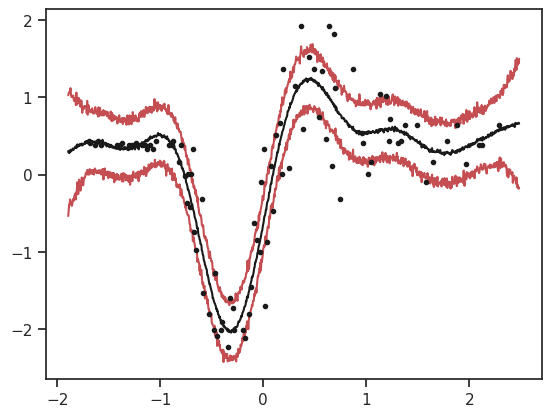

In [11]:
preds_out = pred.get_y()
plt.figure()
plt.plot(X_range, np.mean(preds_out,0), 'k')
plt.plot(X_range, np.quantile(preds_out,0.025,0), 'r')
plt.plot(X_range, np.quantile(preds_out,0.975,0), 'r')
plt.plot(X_train, Y_train, 'k.')
plt.show()

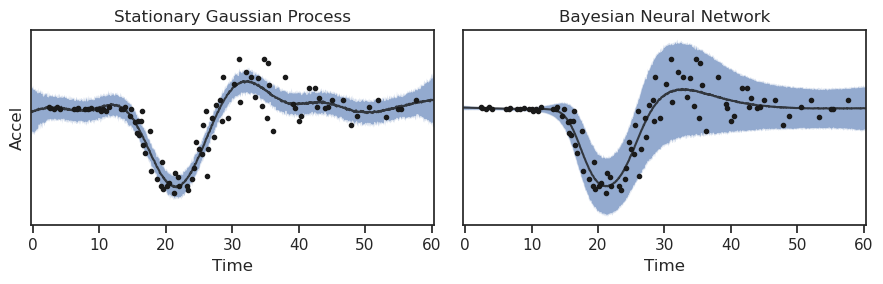

In [19]:
# Joint plot
xrange = [np.min(X_range.detach().numpy()*X_std+X_mean), np.max(X_range.detach().numpy()*X_std+X_mean)]
preds_out = preds_out.squeeze() 

plt.figure(figsize=(9, 3))
ax = plt.subplot(121)
plt.plot(X_range*X_std+X_mean, np.mean(preds_out,0)*Y_std+Y_mean, 'k', alpha=0.8)
#plt.plot(X_range, np.quantile(preds_out,0.025,0), 'r')
#plt.plot(X_range, np.quantile(preds_out,0.975,0), 'r')
plt.fill_between(X_range*X_std+X_mean, np.quantile(preds_out*Y_std+Y_mean,0.025,0), np.quantile(preds_out*Y_std+Y_mean,0.975,0), alpha=0.6)
plt.plot(X_train*X_std+X_mean, Y_train*Y_std+Y_mean, 'k.')
plt.xlabel('Time')
plt.ylabel('Accel')
plt.xlim(xrange)
plt.title('Stationary Gaussian Process')
plt.subplot(122, sharey=ax)
plt.plot(X_range*X_std+X_mean, np.mean(draws*Y_std+Y_mean,0), 'k', alpha=0.8)
#plt.plot(X_range, np.quantile(draws,0.025,0), 'r')
#plt.plot(X_range, np.quantile(draws,0.975,0), 'r')
plt.fill_between(X_range*X_std+X_mean, np.quantile(draws*Y_std+Y_mean,0.025,0), np.quantile(draws*Y_std+Y_mean,0.975,0), alpha=0.6)
plt.plot(X_train*X_std+X_mean, Y_train*Y_std+Y_mean, 'k.')
plt.xlabel('Time')
plt.yticks([])
plt.title('Bayesian Neural Network')
plt.xlim(xrange)
plt.tight_layout()
plt.savefig('data/motor.pdf',bbox_inches='tight')
